## Image Classification

This notebook uses a convolutional neural network (CNN) to classify images in Kaggle's MNIST Digit Recognizer data set.  

Image classification is the task of assigning a label or class to an input image. It is a supervised learning problem, where a model is trained on a labeled dataset of images and their corresponding class labels, and then used to predict the class label of new, unseen images.

This notebook 
1. Downloads and reads the Kaggle MNIST training and test datasets, 
2. Builds a CNN to classify the training data,
3. Predicts the test data, and 
4. Provides a confusion matrix and accuracy metrics.  

Source: https://www.kaggle.com/competitions/digit-recognizer/overview

In [52]:
!pip3 install pydot-ng
!pip3 install graphviz

### Import Libraries

In [49]:
import os
#!pip install kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
import graphviz
import pydot_ng as pydot

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers

from keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.callbacks import Callback 
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model

In [2]:
!mkdir ~/.kaggle
!echo '{"username":"sherylmichael","key":"c75f8d530e0af74d13b7420065cc474b"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

mkdir: /Users/sherilyn/.kaggle: File exists


### Download & Read Kaggle date set, MNIST

In [3]:
#download Kaggle data set
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

api = KaggleApi()
api.authenticate()

cls_list=api.competitions_list(search='mnist')
print(cls_list)

[https://www.kaggle.com/competitions/digit-recognizer]


In [4]:
print(api.competition_list_files('digit-recognizer'))
api.competition_download_files('digit-recognizer')

[sample_submission.csv, test.csv, train.csv]


In [5]:
# Read train & test data
zf = ZipFile('/Users/sherilyn/ds_jungle/computer_vision/classification/multiclass/digit_recognizer/data/digit-recognizer.zip')
zf.extractall('/Users/sherilyn/ds_jungle/computer_vision/classification/multiclass/digit_recognizer/data/digit-recognizer')
zf.close()

In [6]:
train = pd.read_csv(r"/Users/sherilyn/ds_jungle/computer_vision/classification/multiclass/digit_recognizer/data/digit-recognizer/train.csv")
test = pd.read_csv(r"/Users/sherilyn/ds_jungle/computer_vision/classification/multiclass/digit_recognizer/data/digit-recognizer/test.csv")

### Exploring Data

#### Explore train data

In [7]:
print("train shape:", train.shape)
train.head()

train shape: (42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
#missing data
train.isna().sum()

label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64

Count of Unique Lables:  10
Unique labels:  [1 0 4 7 3 5 8 9 2 6]


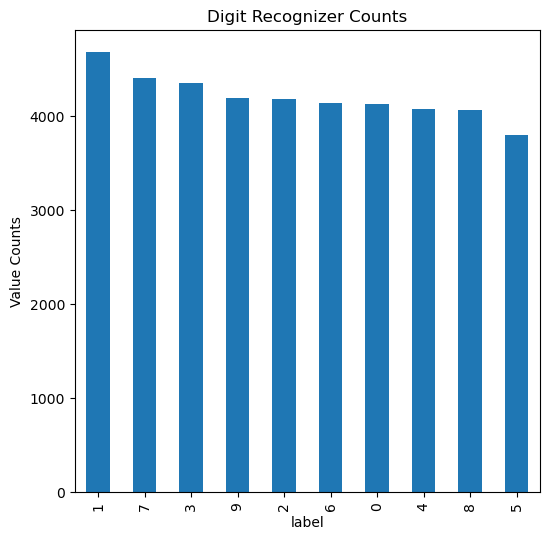

In [9]:
print('Count of Unique Lables: ', train.label.nunique())
print('Unique labels: ', train['label'].unique())
ax = train['label'].value_counts().plot(kind='bar', figsize=(6,6))
fig = ax.get_figure()
ax.set_title("Digit Recognizer Counts")
ax.set_xlabel('label')
ax.set_ylabel('Value Counts');

In [10]:
print("Number of 1: {}".format(len(train[train['label'] == 1])))
print("Number of 5: {}".format(len(train[train['label'] == 5])))

Number of 1: 4684
Number of 5: 3795


Data Summary:

The training data set, train, has 785 columns and 42,000 rows. 
There are no missing data. 
From the data profile on Kaggle, the data set, train, contains gray-scale images of hand-drawn digits, from zero through nine. 
The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image. A value of "0" represents a white image. a value of "1" represents a black image. The data set is relatively balanced for the column, "label"


#### Explore test data

In [11]:
print("test shape:", test.shape)
test.head()

test shape: (28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
#missing data
test.isna().sum()

pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 784, dtype: int64

The test data set, test, has 28000 rows and 784 columns. There are no missing data in test.

Train & test data are categorical. They need to be preprocessed for machine learning models

### Preprocess data

In [15]:
#create target variable, y_train, and feature data, x_train
y_train = train.label
print('y_train.shape: ', y_train.shape)
x_train = train.drop(columns='label')
print('x_train.shape: ', x_train.shape)

y_train.shape:  (42000,)
x_train.shape:  (42000, 784)


In [16]:
#Reshape
#From Kaggle: Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total 
#Normalize pixel values to 0-1 range #From Kaggle: Each pixel-value is an integer between 0 and 255, inclusive.
x_train=x_train.values.reshape(42000,28,28)
x_train=x_train/255
print(x_train.shape)
x_test=test.values.reshape(28000,28,28)
x_test=x_test/255
print(x_test.shape)

(42000, 28, 28)
(28000, 28, 28)


In [18]:
#define input shape
input_shape = (28, 28, 1)

x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
print(x_train.shape)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print(x_test.shape)

(42000, 28, 28, 1)
(28000, 28, 28, 1)


In [19]:
#Label encodings - onehot encode categorical variables
y_train = tf.one_hot(y_train.astype(np.int32), depth=10)

tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(10,), dtype=float32)


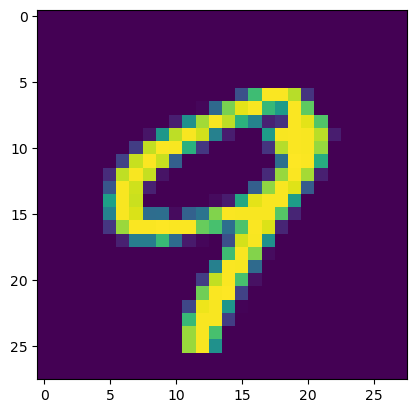

In [20]:
#Visualize Data
plt.imshow(x_train[100][:,:,0])
print(y_train[100])

The image is a handwritten 9. The one-hot encoding suggests the value of 9.

### Build the CNN Model

In [ ]:
#Define parameters for model
batch_size = 32
num_classes = 10
epochs = 10

In [30]:
model = tf.keras.models.Sequential([
    Conv2D(32, (5,5), padding='same', activation='relu', input_shape=input_shape),
    Conv2D(32, (5,5), padding='same', activation='relu'),
    MaxPool2D(),
    Dropout(0.25),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPool2D(strides=(2,2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer=RMSprop(epsilon=1e-08), loss='categorical_crossentropy', metrics=['accuracy'])


### Plot Model

In [50]:
plot_model(model, rankdir='TB',to_file='mnist_cnn.png', dpi=256, show_shapes=True, show_layer_names=True, expand_nested=True, 
                    show_layer_activations=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Fit the Model

In [43]:
# Define callback -> model will stop training if 99.3% accuracy attained

class callback(Callback):
  def training_stopped(self, epoch, logs={}):
    if(logs.get('accuracy')>0.993):
      print("\nTraining stopped, accuracy > 99.3%!")
      self.model.stop_training = True

callbacks = callback()

In [44]:
# Fit training data
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[callbacks])

Epoch 1/10
10/10 [==============================] - 661s 65s/step - loss: 0.4546 - accuracy: 0.8581 - val_loss: 0.2188 - val_accuracy: 0.9308
Epoch 2/10
10/10 [==============================] - 597s 61s/step - loss: 0.3029 - accuracy: 0.9073 - val_loss: 0.1594 - val_accuracy: 0.9500
Epoch 3/10
10/10 [==============================] - 613s 61s/step - loss: 0.3048 - accuracy: 0.9082 - val_loss: 0.1217 - val_accuracy: 0.9617
Epoch 4/10
10/10 [==============================] - 1257s 135s/step - loss: 0.1879 - accuracy: 0.9426 - val_loss: 0.1042 - val_accuracy: 0.9657
Epoch 5/10
10/10 [==============================] - 437s 44s/step - loss: 0.1667 - accuracy: 0.9496 - val_loss: 0.0886 - val_accuracy: 0.9721
Epoch 6/10
10/10 [==============================] - 528s 54s/step - loss: 0.2000 - accuracy: 0.9393 - val_loss: 0.0795 - val_accuracy: 0.9735
Epoch 7/10
10/10 [==============================] - 828s 87s/step - loss: 0.1155 - accuracy: 0.9656 - val_loss: 0.0728 - val_accuracy: 0.9756
Epoc

### Evaluate Model

Text(0.5, 1.0, 'Train - Accuracy')

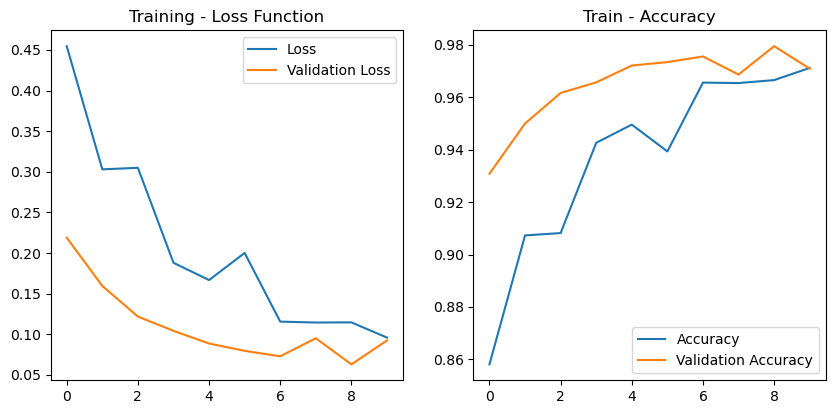

In [46]:
#plot training accuracy vs. loss
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

In [55]:
#using a confusion matrix for validation
y_predicted = tf.argmax(model.predict(x_train),1)
pd.crosstab(y_train, y_predicted, margins=True)

1313/1313 [==============================] - 162s 123ms/step


InvalidArgumentError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [42000,10] vs. [1,42000] [Op:AddV2] name: 

### Predict Test Data

In [ ]:
new_predictions = model.predict(x_test)
new_predictions.shape

In [ ]:
df = pd.DataFrame(new_predictions, columns = ['0','1','2','3','4','5','6','7','8','9'])
df2 = df.sum(axis=0)

# plot new_predictions
df2.plot(x=df2[0], y=df2[1], kind="bar", figsize=(5, 4))
plt.title("Label Counts for new_predictions")
plt.xlabel("Labels")
plt.ylabel("Coounts")
plt.show()